# Measurement Error in the NLSY Mature Women Sample 

Three basic goals:
1. Sort out the data
2. Tabulate match rates
3. Suggestive plots of the discrimination in a few correlates.

## Data Preprocessing and Sanity Checks

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(rc={"figure.figsize" : (8, 6)})
sns.set(font_scale = 1.5) 
sns.set(style="white", color_codes=True)
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5, "figure.figsize" : (8, 4)})

from IPython.display import display

%matplotlib inline

#### Use "tags" in a modified sdf file to have somewhat more readable variable names, for example,

In [2]:
! head -5 tags

#### Load the tag data.  We're going to only keep/use those lines that I've appended meaningful working names to.

In [3]:
columns = {}
for line in open("tags"):
    line = line.strip()
    if not line[101:].count(" "): continue
    spline = line.split()
    k = spline[0].replace(".", "")
    v = spline[-1]
    columns[k] = v

#### Load the data and use the tags to rename the columns.

In [4]:
df = pd.read_csv("mw1.csv")
df.rename(columns = columns, inplace = True)
# sorted(list(df.columns))

#### Check for any duplicate columns -- there aren't any.

In [5]:
s = set()
for xi, x in enumerate(df.columns):
    if x in s: print("Duplicated:", x)
    s.add(x)

#### Just select out the subset of "relevant" columns.

In [6]:
df = df[list(columns.values())].copy(deep = True)
df.set_index("ID1967", inplace = True)

#### Some basic pre-processing -- for race, and flipping from SSA/NDI matches to year of death and match success.

In [7]:
# 1967 to readable labels.
df["RACE1967_LABEL"] = df.RACE1967.replace({2:"Black", 1:"White", 3:"Other"})

# Same thing for the 1995 variable (includes hispanic)
df["RACE1995"] = None
df.loc[df.RACE1995_BLACK == 0, "RACE1995"] = "OTHER"
df.loc[(df.filter(regex = "RACE1995_", axis = 1) ==1 ).any(axis = 1), "RACE1995"] = "HISPANIC"
df.loc[df.RACE1995_BLACK == 1, "RACE1995"] = "BLACK"

# SSA2003 comes as death date; the others come as death age.
# Get all of these in consistently usable formats.
df.loc[df.MOB1967 < 0, "MOB1967"] = 6
df["DOB1967"] = pd.to_datetime(((df.YOB1967 + 1900)*10000 + df.MOB1967 * 100 + 15).astype(str), format='%Y%m%d', errors='coerce')
df["SSAMATCH2003_DOD"] = pd.to_datetime(((df.SSAMATCH2003_YOD)*10000 + df.SSAMATCH2003_MOD * 100 + 15).astype(str), format='%Y%m%d', errors='coerce')
df["SSAMATCH2003_AGE"] = (df.SSAMATCH2003_DOD - df.DOB1967).astype('timedelta64[D]')/365.25
df["NDIMATCH2011_YOD"] = 1900 + df.YOB1967 + df.NDIMATCH2011_AGE
df["SSAMATCH2011_YOD"] = 1900 + df.YOB1967 + df.SSAMATCH2011_AGE
df.loc[(df.YOB1967 < 0) | (df.NDIMATCH2011_AGE < 0), "NDIMATCH2011_YOD"] = -4
df.loc[(df.YOB1967 < 0) | (df.SSAMATCH2011_AGE < 0), "SSAMATCH2011_YOD"] = -4

# Match flags for all three programs.
df["SSAMATCH2003_MATCHED"] = df["SSAMATCH2003_YOD"] > 0
df["NDIMATCH2011_MATCHED"] = df["NDIMATCH2011_AGE"] > 0
df["SSAMATCH2011_MATCHED"] = df["SSAMATCH2011_AGE"] > 0

# For noninterview, mark the "interviewed" and deceased responses.
nonint_years = sorted([int(y[6:]) for y in list(df.filter(regex = "NONINT[0-9]{4}$").columns)])
for y in nonint_years:
    df["NONINT{}_ALIVE".format(y)]    = df["NONINT{}".format(y)] == -4
    df["NONINT{}_DECEASED".format(y)] = df["NONINT{}".format(y)] == 10
    

# Health limitations.
for y in [1971, 1972, 1984, 1986]:
    v = "HL" + str(y)
    df[v] = ""
    df.loc[(df.filter(regex = "^{}_.*".format(v)) > -5).any(axis = 1), v] = "Not Limited"
    df.loc[(df.filter(regex = "^{}_.*".format(v)) >  0).any(axis = 1), v] = "Limited"

#### These match rates are abysmal -- what's going on?  Are they just much more conservative since the women are "harder"??  Well, no -- a lot of them just aren't dead yet.

In [8]:
display(df[["SSAMATCH2003_MATCHED", "NDIMATCH2011_MATCHED", "SSAMATCH2011_MATCHED"]].mean()) 

pd.pivot_table(df[["RACE1967_LABEL", "SSAMATCH2003_MATCHED", "NDIMATCH2011_MATCHED", "SSAMATCH2011_MATCHED"]], 
               columns = ["RACE1967_LABEL"], aggfunc = np.mean)

SSAMATCH2003_MATCHED    0.229982
NDIMATCH2011_MATCHED    0.397600
SSAMATCH2011_MATCHED    0.382255
dtype: float64

RACE1967_LABEL,Black,Other,White
NDIMATCH2011_MATCHED,0.469784,0.356322,0.370771
SSAMATCH2003_MATCHED,0.290647,0.183908,0.207709
SSAMATCH2011_MATCHED,0.434532,0.275862,0.364670


#### Cursory look at the consistency of the two 2011 match programs, conditional on both finding a match.

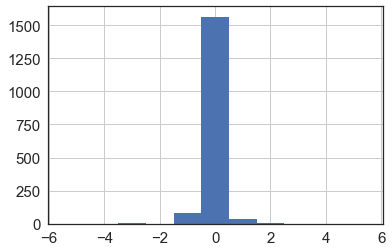

In [9]:
sel = (df["SSAMATCH2011_AGE"] > 0) & (df["NDIMATCH2011_AGE"] > 0)
(df.loc[sel, "SSAMATCH2011_AGE"] - df.loc[sel, "NDIMATCH2011_AGE"]).hist(bins = np.arange(-5.5, 6))

### I really don't get this -- year after year, the total (5083) equals valid skip + 2 × noninterview.  Why? 
* Dan: it's just a mistake.  Chill.

```
R05284.00    [CV]                                           Survey Year: 1982
  PRIMARY VARIABLE


             REASON FOR NONINTERVIEW IN 82

REASON

       1       1 UNABLE TO CONTACT - REASON UNSPECIFIED
       1       2 MOVER (GOOD ADDRESS) INTERVIEW IMPOSSIBLE:DISTANCE TOO GREAT
       2       3 MOVER (GOOD ADDRESS) UNABLE TO INTERVIEW AFTER REPEATED
                      ATTEMPTS
      14       4 MOVER (NO GOOD ADDRESS)
      10       5 NONMOVER - UNABLE TO INTERVIEW AFTER REPEATED ATTEMPTS
       8       6 TEMPORARILY ABSENT
       0       7 IN ARMED FORCES
       4       8 INSTITUTIONALIZED
    1061       9 REFUSED
     238      10 DECEASED
       5      11 OTHER
     193      12 NON-INTERVIEW TWO YEARS, RESPONDENT DROPPED FROM SAMPLE
       4      13 MOVED OUTSIDE U.S. (OTHER THAN ARMED FORCES)
  -------
    1541

Refusal(-1)            0
Don't Know(-2)         0
TOTAL =========>    1541   VALID SKIP(-4)    2001     NON-INTERVIEW(-5)    1541
```

In [10]:
print("The total number of respondents is:", df.shape[0])
print("The total zero-weights equals the number of non-interviews:", (df.W1982 == 0).sum())
print("By the way, the sums are just a coincidence??", 1541+2001, 2*1541+2001)
print("But the non-interviews are set to -4 (cdb says it should be 2001) (?):", (df.NONINT1982 == -5).sum(), (df.NONINT1982 == -4).sum())
print("And one cannot separate them by requiring nonzero weight:", ((df.NONINT1982 == -4) & (df.W1982 == 0)).sum())
print("But if I count them up, I'm not sure how to separate these.  The weights are all non-zero:", (df.W1982 > 0).sum())
print("So who are these other 1541 people, and what happened to them??")

print("BTW, I am not crazy:")
! cat mw1.csv | cut -f113 -d, | sort | uniq -c

The total number of respondents is: 5083
The total zero-weights equals the number of non-interviews: 1541
By the way, the sums are just a coincidence?? 3542 5083
But the non-interviews are set to -4 (cdb says it should be 2001) (?): 0 3542
And one cannot separate them by requiring nonzero weight: 0
But if I count them up, I'm not sure how to separate these.  The weights are all non-zero: 3542
So who are these other 1541 people, and what happened to them??
BTW, I am not crazy:
      1 1
    238 10
      5 11
    193 12
      4 13
      1 2
      2 3
     14 4
   3542 -4
     10 5
      8 6
      4 8
   1061 9
      1 "R0528400"


## Basic Data Analysis

Start by looking for three cases:
1. death after non-interview due to death (D>NI),
   * Extremely low for all programs.
2. interview after a death date from a match program (I > D),
   * "Very low" but marginally higher for the 2011 matches.
3. no death record after non-interview due to death (NR, fraction).
   * High failure to match for all programs in early data, improving dramatically but not completely over time.

In [11]:
ssa03A, ndi11A, ssa11A = {}, {}, {}
ssa03D, ndi11D, ssa11D = {}, {}, {} 
ssa03NR, ndi11NR, ssa11NR = {}, {}, {} 
for y in nonint_years:
    va = "NONINT" + str(y) + "_ALIVE"
    vd = "NONINT" + str(y) + "_DECEASED"
    ssa03A[y]  = (df[va] & (df.SSAMATCH2003_YOD > 0) & (df.SSAMATCH2003_YOD < y-2)).sum()
    ndi11A[y]  = (df[va] & (df.NDIMATCH2011_YOD > 0) & (df.NDIMATCH2011_YOD < y-2)).sum()
    ssa11A[y]  = (df[va] & (df.SSAMATCH2011_YOD > 0) & (df.SSAMATCH2011_YOD < y-2)).sum()
    ssa03D[y]  = (df[vd] & (df.SSAMATCH2003_YOD > 0) & (df.SSAMATCH2003_YOD > y+2)).sum()
    ndi11D[y]  = (df[vd] & (df.NDIMATCH2011_YOD > 0) & (df.NDIMATCH2011_YOD > y+2)).sum()
    ssa11D[y]  = (df[vd] & (df.SSAMATCH2011_YOD > 0) & (df.SSAMATCH2011_YOD > y+2)).sum()

    ssa03NR[y] = (df[vd] & (df.SSAMATCH2003_YOD < 0)).sum() / df[vd].sum()
    ndi11NR[y] = (df[vd] & (df.NDIMATCH2011_AGE < 0)).sum() / df[vd].sum()
    ssa11NR[y] = (df[vd] & (df.SSAMATCH2011_AGE < 0)).sum() / df[vd].sum()

pd.DataFrame({"SSA03 D>NI" : ssa03D,  "NDI11 D>NI" : ndi11D,  "SSA11 D>NI" : ssa11D,
              "SSA03 I>D"  : ssa03A,  "NDI11 I>D"  : ndi11A,  "SSA11 I>D"  : ssa11A,
              "SSA03 NR"   : ssa03NR, "NDI11 NR"   : ndi11NR, "SSA11 NR"   : ssa11NR})

,NDI11 D>NI,NDI11 I>D,NDI11 NR,SSA03 D>NI,SSA03 I>D,SSA03 NR,SSA11 D>NI,SSA11 I>D,SSA11 NR
1968,2,0,0.727273,0,0,0.727273,1,1,0.681818
1969,2,0,0.742857,0,0,0.742857,1,1,0.714286
1971,3,0,0.716667,2,0,0.716667,3,1,0.700000
1972,3,0,0.722222,2,0,0.708333,3,1,0.694444
1974,4,0,0.603960,3,0,0.594059,4,1,0.623762
1976,5,0,0.564885,3,0,0.557252,4,1,0.603053
1977,6,0,0.550000,4,0,0.542857,5,1,0.585714
1979,6,0,0.488636,4,0,0.482955,6,1,0.522727
1981,9,0,0.412037,4,0,0.439815,7,1,0.472222
1982,9,1,0.378151,4,0,0.420168,7,1,0.457983


1. How are dead respondents classified?  If you were not interviewed (positive non-interview reason), and have an NDI-recorded death (positive) 2 or more years before the date at which you were not interviewed, what is the reason given for noninterview?  (These should add to 1.)  
    * We see somewhat substantial recording as "Refused."  Presumably the family is just telling the NLS to get lost...
2. If you are not interviewed (reason for reason), what is the chance that we've found an appropriate death record?  This convolutes the probabilities of match and correct enough (≤ interview) match.
    * This reproduces the fairly low rate of finding the record that we saw above, for the actually deceased.  It also shows "refused" is sometimes a euphemism for dead.  N.B. that for this one I'm doing match year ≤ interview year.  So this could overstate the refused rate in some sense: Charlotte could refuse interview from her deathbed...

In [12]:
pd.options.display.float_format = '{:,.2f}'.format

nonint_map = {1 : "Unspecified", 2 : "Mover/Impossible", 3 : "Mover/Repeated Attempts", 4 : "Mover/No Address",
              5 : "Nonmover/Repeated Attempts", 6 : "Absent", 7 : "Armed Forces", 8 : "Institutionalized", 
              9 : "Refused", 10 : "Deceased", 11 : "Other", 12 : "Dropped (2yrs)", 13 : "Outside US", 
              14 : "Cong. Refusal"}

ndi_dead_df = pd.DataFrame()
nonint_df = pd.DataFrame()
for y in nonint_years:
    v = "NONINT" + str(y)
    df["Reason"] = df[v].map(nonint_map)
    df["NDI Dead " + str(y)] = (df.NDIMATCH2011_YOD > 0) & (df.NDIMATCH2011_YOD <= y)

    mask = (df[v] > 0) & (df.NDIMATCH2011_YOD > 0) & (df.NDIMATCH2011_YOD <= y-2)
    dfy = df.loc[mask, ["Reason", v]].groupby("Reason").count()[[v]]
    ndi_dead_df = ndi_dead_df.append((dfy[v]/dfy[v].sum()).T)
    
    nonint_df = nonint_df.append(df.loc[df[v] > 0, ["Reason", "NDI Dead " + str(y), "NDIMATCH2011_YOD"]].groupby("Reason").mean()[["NDI Dead " + str(y)]].T)

ndi_dead_df.fillna(0, inplace = True)
nonint_df.fillna(0, inplace = True)

display(ndi_dead_df)
display(nonint_df[["Deceased", "Refused", "Dropped (2yrs)"]])

,Deceased,Refused,Dropped (2yrs),Mover/No Address
NONINT1968,1.00,0.00,0.00,0.00
NONINT1969,1.00,0.00,0.00,0.00
NONINT1971,1.00,0.00,0.00,0.00
NONINT1972,1.00,0.00,0.00,0.00
NONINT1974,0.97,0.03,0.00,0.00
NONINT1976,0.92,0.04,0.02,0.02
NONINT1977,0.95,0.04,0.02,0.00
NONINT1979,0.90,0.06,0.04,0.00
NONINT1981,0.88,0.07,0.05,0.00
NONINT1982,0.84,0.10,0.06,0.00


Reason,Deceased,Refused,Dropped (2yrs)
NDI Dead 1968,0.18,0.00,0.00
NDI Dead 1969,0.20,0.00,0.00
NDI Dead 1971,0.22,0.00,0.00
NDI Dead 1972,0.22,0.00,0.00
NDI Dead 1974,0.35,0.00,0.01
NDI Dead 1976,0.40,0.01,0.02
NDI Dead 1977,0.41,0.01,0.02
NDI Dead 1979,0.48,0.01,0.04
NDI Dead 1981,0.54,0.02,0.04
NDI Dead 1982,0.58,0.03,0.05


* Correct match rates over time, again.  Moving from one interview to the next, if you go from "interviewed" to "deceased," what is the likelihood that the NDI match finds a death record within that range (expanded by 1 year either way).

In [13]:
for y1, y2 in zip(nonint_years[1:-1], nonint_years[2:]):
    v1 = "NONINT" + str(y1)
    v2 = "NONINT" + str(y2)
    newly_marked = (df[v1] == -4) & (df[v2] == 10)
    df["range"]  = (y1-1 < df["NDIMATCH2011_YOD"]) & (df["NDIMATCH2011_YOD"] < y2 + 1)
    fraction_found = df.loc[newly_marked, "range"].mean()

    print(v1, "-", y2, y1-1, y2+1, fraction_found)
    # display(df.loc[newly_marked, ["NDIMATCH2011_YOD", "range"]])
    

NONINT1969 - 1971 1968 1972 0.25
NONINT1971 - 1972 1970 1973 0.166666666667
NONINT1972 - 1974 1971 1975 0.464285714286
NONINT1974 - 1976 1973 1977 0.5
NONINT1976 - 1977 1975 1978 0.375
NONINT1977 - 1979 1976 1980 0.666666666667
NONINT1979 - 1981 1978 1982 0.72972972973
NONINT1981 - 1982 1980 1983 0.761904761905
NONINT1982 - 1984 1981 1985 0.818181818182
NONINT1984 - 1986 1983 1987 0.82
NONINT1986 - 1992 1985 1993 0.909574468085


## Correlates of Life Expectancy

#### Race, measured in 1967.  Whites better off.

RACE1967_LABEL
Black    Axes(0.125,0.125;0.775x0.755)
Other    Axes(0.125,0.125;0.775x0.755)
White    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

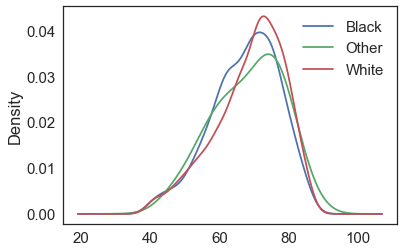

In [14]:
df[df.NDIMATCH2011_AGE > 30].groupby("RACE1967_LABEL").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

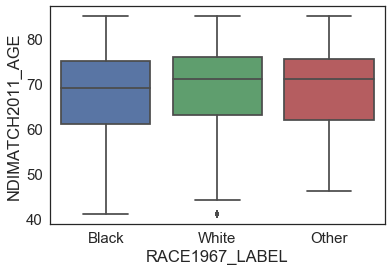

In [15]:
sns.boxplot(x="RACE1967_LABEL", y="NDIMATCH2011_AGE", data = df[df.NDIMATCH2011_AGE > 30])

#### Race, measured in 1995 -- pushes the distribution to the left, separate out Hispanics.

RACE1995
BLACK       Axes(0.125,0.125;0.775x0.755)
HISPANIC    Axes(0.125,0.125;0.775x0.755)
OTHER       Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

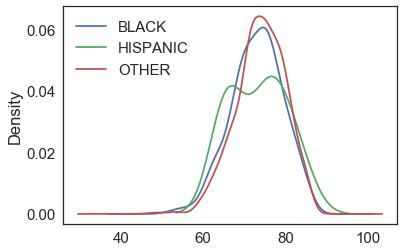

In [16]:
df[~df.RACE1995.isnull() & (df.NDIMATCH2011_AGE > 0)].groupby("RACE1995").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

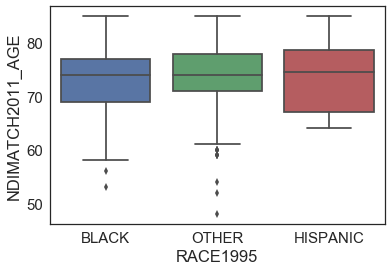

In [17]:
sns.boxplot(x="RACE1995", y="NDIMATCH2011_AGE", data = df[~df.RACE1995.isnull() & (df.NDIMATCH2011_AGE > 0)])

#### Health Limitations in 1971, 1972, 1984, 1986.

HL1971
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

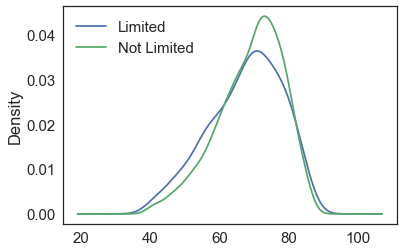

In [18]:
df[df.HL1971.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1971").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

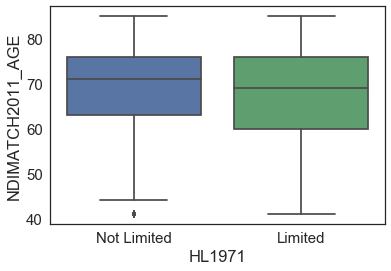

In [19]:
sns.boxplot(x="HL1971", y="NDIMATCH2011_AGE", data = df[df.HL1971.astype(bool) & (df.NDIMATCH2011_AGE > 30)])

HL1972
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

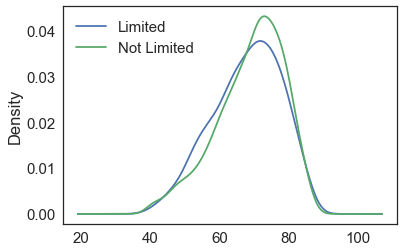

In [20]:
df[df.HL1972.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1972").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

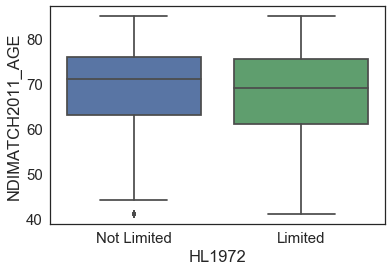

In [21]:
sns.boxplot(x="HL1972", y="NDIMATCH2011_AGE", data = df[df.HL1972.astype(bool) & (df.NDIMATCH2011_AGE > 30)])

HL1984
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

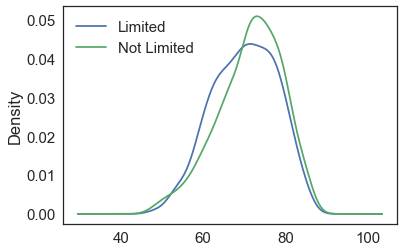

In [22]:
df[df.HL1984.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1984").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

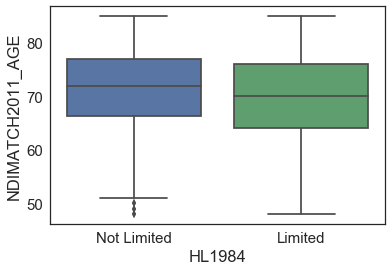

In [23]:
sns.boxplot(x="HL1984", y="NDIMATCH2011_AGE", data = df[df.HL1984.astype(bool) & (df.NDIMATCH2011_AGE > 30)])

HL1986
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

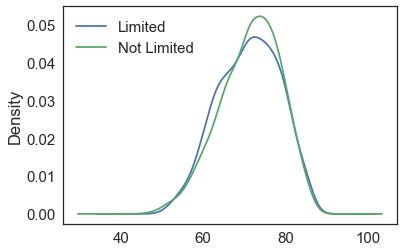

In [24]:
df[df.HL1986.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1986").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

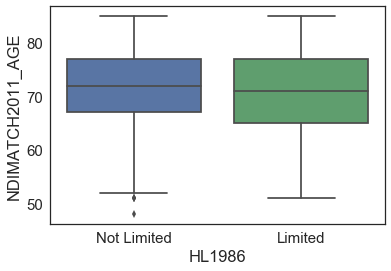

In [25]:
sns.boxplot(x="HL1986", y="NDIMATCH2011_AGE", data = df[df.HL1986.astype(bool) & (df.NDIMATCH2011_AGE > 30)])

#### Marital Status.

MARSTAT1967
No Spouse Present    Axes(0.125,0.125;0.775x0.755)
Spouse Present       Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

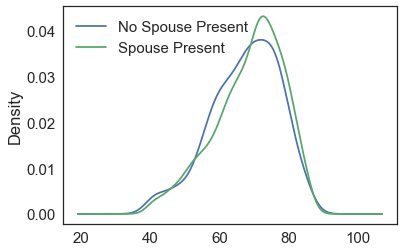

In [26]:
df[(df.NDIMATCH2011_AGE > 0)].replace({"MARSTAT1967" : {1 : "Spouse Present",
                                                        2 : "No Spouse Present",
                                                        3 : "No Spouse Present",
                                                        4 : "No Spouse Present",
                                                        5 : "No Spouse Present",
                                                        6 : "No Spouse Present"}})\
                             .groupby("MARSTAT1967")\
                             .NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

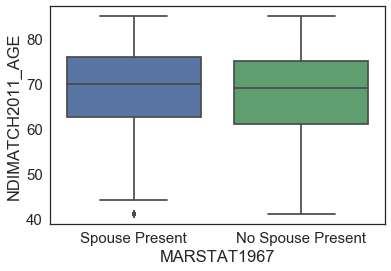

In [27]:
sns.boxplot(x="MARSTAT1967", y="NDIMATCH2011_AGE", data = df[(df.NDIMATCH2011_AGE > 0)].replace({"MARSTAT1967" : {1 : "Spouse Present",
                                                        2 : "No Spouse Present",
                                                        3 : "No Spouse Present",
                                                        4 : "No Spouse Present",
                                                        5 : "No Spouse Present",
                                                        6 : "No Spouse Present"}}))

#### It's easy to keep adding these -- smokers, income, etc.  But there is clearly some power here.

also look at the national health interview studies
 → IPUMS has it well-formatted.